## Coastline Changes

By Jon, Damian and Martyna

## Environment Setup Instructions

First create an Anaconda environment and install geemap:

conda create -n gee python

conda activate gee

conda install mamba -c conda-forge

mamba install geemap -c conda-forge


## General Information
Landsat 5 and Landsat 8 are satellites and each satellite has image collections. Satellites also have a launch date and in some cases a date when the satellite is no longer in service. The Landsat 5 has three datasets which are the Surface Reflectance, Top of Atmosphere, and Raw Images datasets/image collections. This algorithm will only use the Surface Reflectance image collection.<br>
Landsat 5 was in service from March 1984 to May 2012 and we will use this data to get the "Before" images of the coastline.
Landsat 8 was in service from April 2014 and is still in service today. We will use the this data to get the "Recent" image of the coastline.<br>
<br>
Landsat 5 collecton surface reflection (March 1984 - May 2012)<br>
Collection ID: **LANDSAT/LT05/C01/T1_SR**<br>
<br>
Landsat 8 collection surface reflection(April 2013 - Present)<br>
Collection ID: **LANDSAT/LC08/C01/T1_SR**<br>

## The Algorithm
### Introduction
To summarize the program and the algorithm the user will first be given instructions. They can select a region they would like the algorithm to perform coastline detection on or they can just see the algorithm work with a pre-defined region.<br>
As soon as the user enter's full screen mode as per instructions the image obtaining process will begin.<br>
Firstly the map is centered around the defined region. This is to ensure the region we want to displaying on screen regardless of where the map was displaying previously. Next the program will load and take an image of each band. Each band represents a colour and some are not visible to the human eye normally. These bands include the basic Red, Green and Blue. These band images are grayscale and can be combined into an RGB image for example<br>
<br>
There are six bands for landsat 5 and seven bands for landsat 8 that we are going to use in this algorithm and two time frames. Meaning the program will be working with 13 images.<br>
The Red, Green and Blue images are combined into one RGB image.<br>
K-Means segmentation will be used to seperate the water from land in each image. The images will be converted to binary and "combined" into one image. This image will be blurred wth a Gaussian blur to reduce noise and a coastline will be obtained with Canny edge detection and redrawn in a different colour using Contours functions. The contours will be displayed on top of the RGB images and finally the contours will be combined and drawn on top of the present day image to show how much the coastline has changed.<br>

In [1]:
import os
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import re
import cv2
import easygui
import time

In [2]:
"""
This method is used for displaying images at once. This provides a convenient central point of access to displaying images
"""
def displayImages(imageArray, titleArray, rows, columns):
    # Error checking
    if imageArray is None or titleArray is None:
        print("imageArray or titleArray is None")
        return
    if len(imageArray) != len(titleArray):
        print("Image array size does not math title array size!")
        return
    if rows is None:
        rows = 9
    if columns is None:
        columns = 2
    
    fig = plt.figure(num=None, figsize=(20, 60), dpi=80, facecolor='w', edgecolor='k')
    plt.rc('font', size=10)

    for i in range(len(imageArray)):
        place = str(rows) + str(columns) + str(i + 1)
        place = int(place)
        
        fig.add_subplot(int(rows), int(columns), int(i + 1))
        plt.title(titleArray[i])
        plt.set_cmap('gray')
        plt.imshow(imageArray[i]);
        

"""
The images are taken from the screen and the image is cropped to remove any parts that are not necessary.
This way we get the region we want exactly.
"""
def cropImageFromCentre(img, crop_w, crop_h):
    h, w, d = img.shape

    cropSizeFromCentre = (crop_w, crop_h)
    x = int(w/2)
    y = int(h/2)
    pt1 = (x - int(crop_w/2), y - int(crop_h/2))
    pt2 = (x + int(crop_w/2), y + int(crop_h/2))

    croppedImage = img[pt1[1] : pt2[1], pt1[0] : pt2[0]]

    return croppedImage


"""
The map is generated and displayed on screen for the user to interact with. This method centers the map on a region.
"""
def generateMap(longitude, latitude, zoom):
    global regionOfInterestPoint
    if zoom == None:
        zoom = 11
        
    if longitude == None or latitude == None:
        Map = geemap.Map(center=(44.580014, -1.248944), zoom=zoom)
        regionOfInterestPoint = ee.Geometry.Point(-1.248944, 44.580014)
    else:
        Map = geemap.Map(center=(latitude, longitude), zoom=zoom)
        regionOfInterestPoint = ee.Geometry.Point(longitude, latitude)
        
    return Map


"""
The user can define their own region on the map using a marker. A button for the marker is on the map.
If a user has define a point on the map the program will obtain the point that was most recently drawn and
centers the map around that point. This method is used to get the longitude and latitude of the point.
"""
def getLastDrawnPoint():
    feature = Map.draw_last_feature
    zoom = 11
    if feature != None:
        # Extract coordinates
        featureInfo = feature.getInfo()
        featureType = featureInfo.get("geometry").get("type")
        featureCoords = featureInfo.get("geometry").get("coordinates")
        featureCoords = {"longitude" : float(featureCoords[0]), "latitude" : float(featureCoords[1])}
    
        return featureCoords
    
    else:
        return None
    

"""
This method returns a list of cropped images of the various bands.
The imageCollectionID is the ID of the image collection, this could be either landsat 5 or landsat 8. Each landsat satellite
is associated with a certain time frame. So we would use landsat 5 images if we want older images and landsat 8 if we 
want the most recent ones. We also pass the start date and end date range for the time frame we want the images from.
Finally we pass the bands of the images we would like to retrieve. 
This method gets the optimal image (least cloudy) given the parameters and then obtains a single each for each band from
that optimal image. The image is cropped and stored to an array.

"""
def getBandImagesFromSatellite(imageCollectionID, regionOfInterestPoint, startDate, endDate, bands):
    # Get image collection
    landsatCollection = ee.ImageCollection(imageCollectionID)
    # Filter by region
    areaOfInterest = landsatCollection.filterBounds(regionOfInterestPoint)
    # Filter by date
    landsat = landsatCollection.filterDate(startDate, endDate)
    # Least cloudly image from the collection is chosen
    leastCloudyImage = ee.Image(areaOfInterest.sort('CLOUD_COVER').first())

    print('Total number:', areaOfInterest.size().getInfo())
    print(leastCloudyImage.get('CLOUD_COVER').getInfo())

    landsatBandImages = []
    titleArray = []
    for band in bands:
        visualParams = {
            'min': 0,
            'max': 5000,
            'bands': band
        }
        Map.addLayer(leastCloudyImage, visualParams)

        time.sleep(5)
        # Temporairly save image using the Geemap method
        Map.to_image(outfile=os.getcwd() + "\\" + "BandImg.png", monitor=1)
        # Read the image in
        img = cv2.imread("BandImg.png")
        # Crop image
        croppedImg = cropImageFromCentre(img, 600, 600)
        # Store image in array
        landsatBandImages.append(croppedImg)
        # Store band image title in array
        titleArray.append(str(band))
    
    return landsatBandImages, titleArray


"""
An RGB image can be created from the Red, Green and Blue bands. In other words we can create a RGB image from
3 grayscale images.
"""
def getRGBFromImages(redImageBGR, greenImageBGR, blueImageBGR):
    R_HSV = cv2.cvtColor(redImageBGR, cv2.COLOR_BGR2HSV)
    r = R_HSV[:,:,2]

    G_HSV = cv2.cvtColor(greenImageBGR, cv2.COLOR_BGR2HSV)
    g = G_HSV[:,:,2]

    B_HSV = cv2.cvtColor(blueImageBGR, cv2.COLOR_BGR2HSV)
    b = B_HSV[:,:,2]

    BGR = cv2.merge([r, g, b])
    RGB = cv2.cvtColor(BGR, cv2.COLOR_BGR2RGB)
    
    return RGB


"""
K-Means segmentation is performed on the images passed to this method and an array of images is returned.
K-Means segments the images into two categories which are land and water.
"""
def getKmeansImages(images):
    kmeansImages = []
    
    # Perform K-Means on each of the images
    for index in range(len(images)):
        img = images[index]

        # Image pixel array is reshaped into a 1D array (similar to ravel method)
        Z = img.reshape((-1,3))
        Z = np.float32(Z)

        # Perform K-Means
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        K = 2
        ret,label,center=cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Now convert back into uint8, and make original image
        center = np.uint8(center)
        res = center[label.flatten()]
        res2 = res.reshape((img.shape))

        kmeansImages.append(res2)
    
    return kmeansImages


"""
The K-Means images (an image for each band) are converted to binary and combined with a bitwise_or() method.
"""
def getBinaryCombinedImage(imageArray):
    binaryImages = []
    height, width, depth = imageArray[0].shape 

    # Create an empty black image with numpy.zeros
    combinedImage = np.zeros((height,width), np.uint8)
    # Combining with bitwise_or()
    for img in imageArray:
        # Convert images to binary images
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        (thresh, img_binary) = cv2.threshold(img_gray, 50, 255, cv2.THRESH_BINARY)

        # Combine the previously combined image with the new binary image
        combinedImage = cv2.bitwise_or(combinedImage, img_binary)

        # Store images in array
        binaryImages.append(img_binary)
    
    return combinedImage, binaryImages


"""
The edges of the binary image (post-segmentation) are obtained with Canny edge detection.
The contours of the edges are obtained and drawn on a black image in a specified colour.
"""
def obtainAndDrawingEdges(image, contourColourRGB):
    h, w = image.shape
    
    # Get edges of the faded region
    edged = cv2.Canny(image, 70, 200)
    
    # Get contours of the edges
    # cv2.RETR_EXTERNAL retrieves only the extreme outer contours.
    # cv2.CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments and leaves only their end points.
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Image that the contours will be drawn on (black image initially)
    imageForContours = np.zeros((h, w, 3), np.uint8)
    contourSize = 1
    
    cv2.drawContours(imageForContours, contours, -1, contourColourRGB, contourSize);
    
    return edged, imageForContours

In [3]:
def main():
    global regionOfInterestPoint
    
    # Image collection names are initalized here, each collection corresponds to a satellite
    # Each satelite has been taking images at a certain time frame
    """ ****************************************************************************************************************************************************
    IMAGE RETRIEVAL
    **************************************************************************************************************************************************** """
    collections = {
    'landsat5': 'LANDSAT/LT05/C01/T1_SR',
    'landsat8': 'LANDSAT/LC08/C01/T1_SR'}

    print("Starting retrieval")
    # Center map around last drawn point
    lastDrawnPoint = getLastDrawnPoint()
    if lastDrawnPoint != None:
        zoom = 11
        longitude = lastDrawnPoint["longitude"]
        latitude = lastDrawnPoint["latitude"]
        regionOfInterestPoint = ee.Geometry.Point(longitude, latitude)


    # Center map
    roipCoords = regionOfInterestPoint.getInfo()["coordinates"]
    Map.setCenter(roipCoords[0], roipCoords[1], 11)

    # Select Landsat 5 collection
    imageCollectionID = collections['landsat5']
    startDate = '1990-01-01'
    endDate = '1990-12-31'
    bands = [['B1'], ['B2'], ['B3'], ['B4'], ['B5'], ['B7']]
    landsat5_BandImages, landsat5_BandNames = getBandImagesFromSatellite(imageCollectionID, regionOfInterestPoint, startDate, endDate, bands)

    # Select Landsat 8 collection
    imageCollectionID = collections['landsat8']
    startDate = '2018-01-01'
    endDate = '2018-12-31'
    bands = [['B1'], ['B2'], ['B3'], ['B4'], ['B5'], ['B6'], ['B7']]
    landsat8_BandImages, landsat8_BandNames = getBandImagesFromSatellite(imageCollectionID, regionOfInterestPoint, startDate, endDate, bands)
    
    # Images have been retrieved so this variable is set to False. Otherwise going into fullscreen will invoke the
    # algorithm. 
    imageRetrivalStarted = False
    easygui.msgbox("Finished, Please exit fullscreen")
    
    # Get RGB Image from the Red, Green and Blue band images
    landsat5_RGB = getRGBFromImages(landsat5_BandImages[0], landsat5_BandImages[1], landsat5_BandImages[2])
    landsat8_RGB = getRGBFromImages(landsat8_BandImages[1], landsat8_BandImages[2], landsat8_BandImages[3])

    displayImages([landsat5_RGB, landsat8_RGB], ["landsat5_RGB", "landsat8_RGB"], 9, 2)

    # Display Band Images
    # displayImages(landsat5_BandImages, landsat5_BandNames, 9, 2)
    displayImages(landsat8_BandImages, landsat8_BandNames, 9, 2)
    
    combinedImages = []
    combinedImageTitles = []
    
    
    
    """ ****************************************************************************************************************************************************
    SEGMENTATION
    **************************************************************************************************************************************************** """

    kmeansImages = getKmeansImages(landsat5_BandImages.copy())
    combinedImage, binaryImages = getBinaryCombinedImage(kmeansImages)

    combinedImageTitles.append("Combined Landsat 5 (1990)")
    combinedImages.append(combinedImage)

    # Display K-Means Images
    # displayImages(kmeansImages, landsat5_BandNames, 9, 2)

    # Display K-Means Images in binary
    # displayImages(binaryImages, landsat5_BandNames, 9, 2)

    # --------------------------------------------------------------------------------------------------------------------

    kmeansImages = getKmeansImages(landsat8_BandImages.copy())
    combinedImage, binaryImages = getBinaryCombinedImage(kmeansImages)

    combinedImageTitles.append("Combined Landsat 8 (2018)")
    combinedImages.append(combinedImage)

    # Display K-Means Images
    # displayImages(kmeansImages, landsat8_BandNames, 9, 2)

    # Display K-Means Images in binary
    displayImages(binaryImages, landsat8_BandNames, 9, 2)

    # --------------------------------------------------------------------------------------------------------------------

    displayImages(combinedImages, combinedImageTitles, 9, 2)
    
    blurredImages = [cv2.GaussianBlur(combinedImage, (11,11), 0) for combinedImage in combinedImages]
    titles = ["Blurred Combined Landsat 5 (1990)", "Blurred Combined Landsat 8 (2018)"]
    displayImages(blurredImages, combinedImageTitles, 9, 2)
    
    
    """ ****************************************************************************************************************************************************
    COASTLINE DETECTION
    **************************************************************************************************************************************************** """
    
    # Get contours and redraw with a different colour
    # edged image is just the image from Canny Edge detection. 
    # contoured image is the same thing but redrawn with a different colour
    landsat5_edged, landsat5_contoured = obtainAndDrawingEdges(blurredImages[0], (255, 255, 0))
    landsat8_edged, landsat8_contoured = obtainAndDrawingEdges(blurredImages[1], (255, 0, 0))

    # Combine the contours with their respective RGB satellite image
    # Landsat 5
    # An inverse mask is created so that the coloured contours stand out and do no blend with the image
    landsat5_inverse = ~landsat5_edged
    # The pixels where the contours go on top of the RGB image are turned black to prevent blending
    landsat5_preparedRGB = cv2.bitwise_and(landsat5_RGB, landsat5_RGB, mask = landsat5_inverse)
    # Contoured image and the RGB image (post mask) are combined
    edgesOnRGB_landsat5 = cv2.bitwise_or(landsat5_contoured, landsat5_preparedRGB)

    # Landsat 8
    landsat8_inverse = ~landsat8_edged
    landsat8_preparedRGB = cv2.bitwise_and(landsat8_RGB, landsat8_RGB, mask = landsat8_inverse)
    edgesOnRGB_landsat8 = cv2.bitwise_or(landsat8_contoured, landsat8_preparedRGB)

    # Put both contours on the most recent RGB satellite image (landsat 8 RGB + Both contours)
    # Contours are combined
    combinedContours = cv2.bitwise_or(landsat5_contoured, landsat8_contoured)
    # An inverse mask is used to prepare the RGB image for the contours to go on top
    combinedContoursMask = cv2.bitwise_or(landsat5_edged, landsat8_edged)
    inverseCombinedMask = ~combinedContoursMask
    landsat8_RGB_final = cv2.bitwise_and(landsat8_RGB, landsat8_RGB, mask = inverseCombinedMask)
    final = cv2.bitwise_or(combinedContours, landsat8_RGB_final)


    titles = [
        "landsat5_inverse",
        "landsat5_preparedRGB",
        "Edges Landsat 5 (1990)", 
        "Edges Landsat 8 (2018)", 
        "Edges on RGB Landsat 5 (1990)", 
        "Edges on RGB Landsat 8 (2018)", 
        "Combined Edges", 
        "Combined Edges on RGB Landsat 8 (2018)"
        ]

    imagesToDisplay = [
        landsat5_inverse,
        landsat5_preparedRGB,
        landsat5_contoured, 
        landsat8_contoured, 
        edgesOnRGB_landsat5, 
        edgesOnRGB_landsat8, 
        combinedContours,
        final
    ]

    displayImages(imagesToDisplay, titles, 9, 2)


Map(center=[44.580014, -1.248944], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleB…

Fullscreen is:  True
Starting retrieval
Total number: 343
0
Total number: 216
0


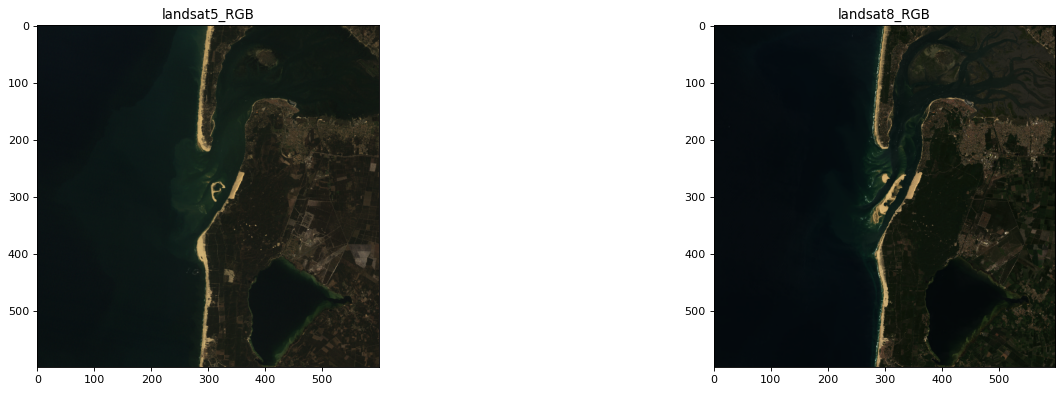

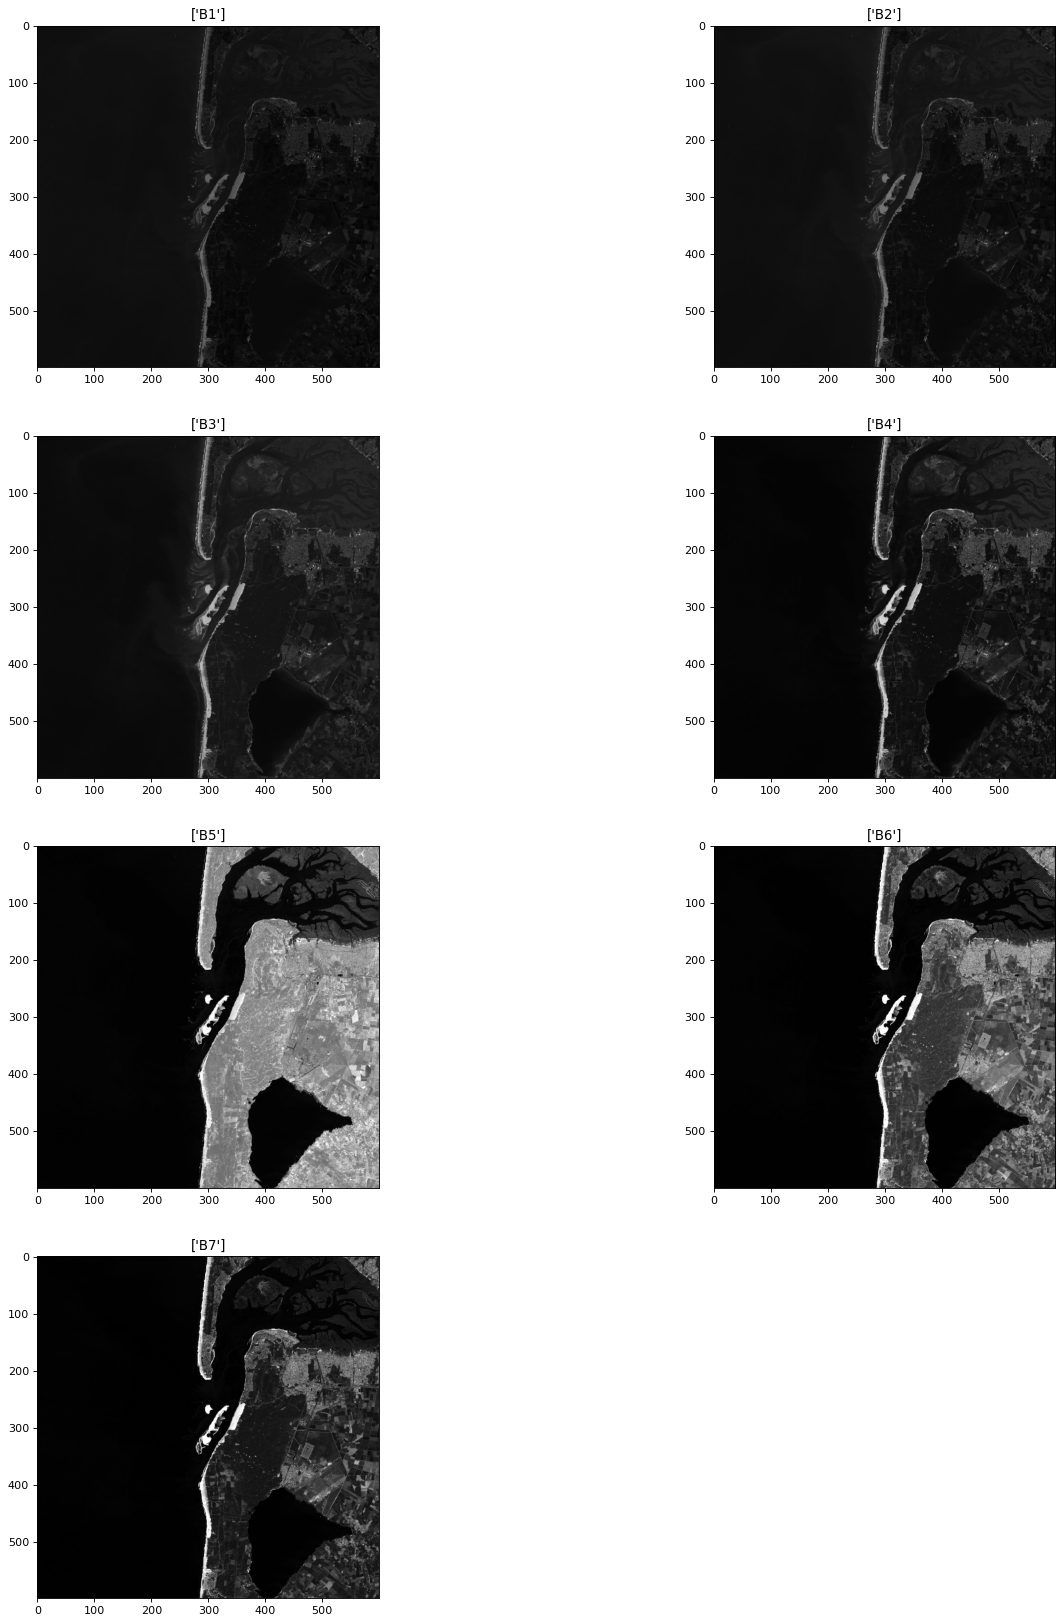

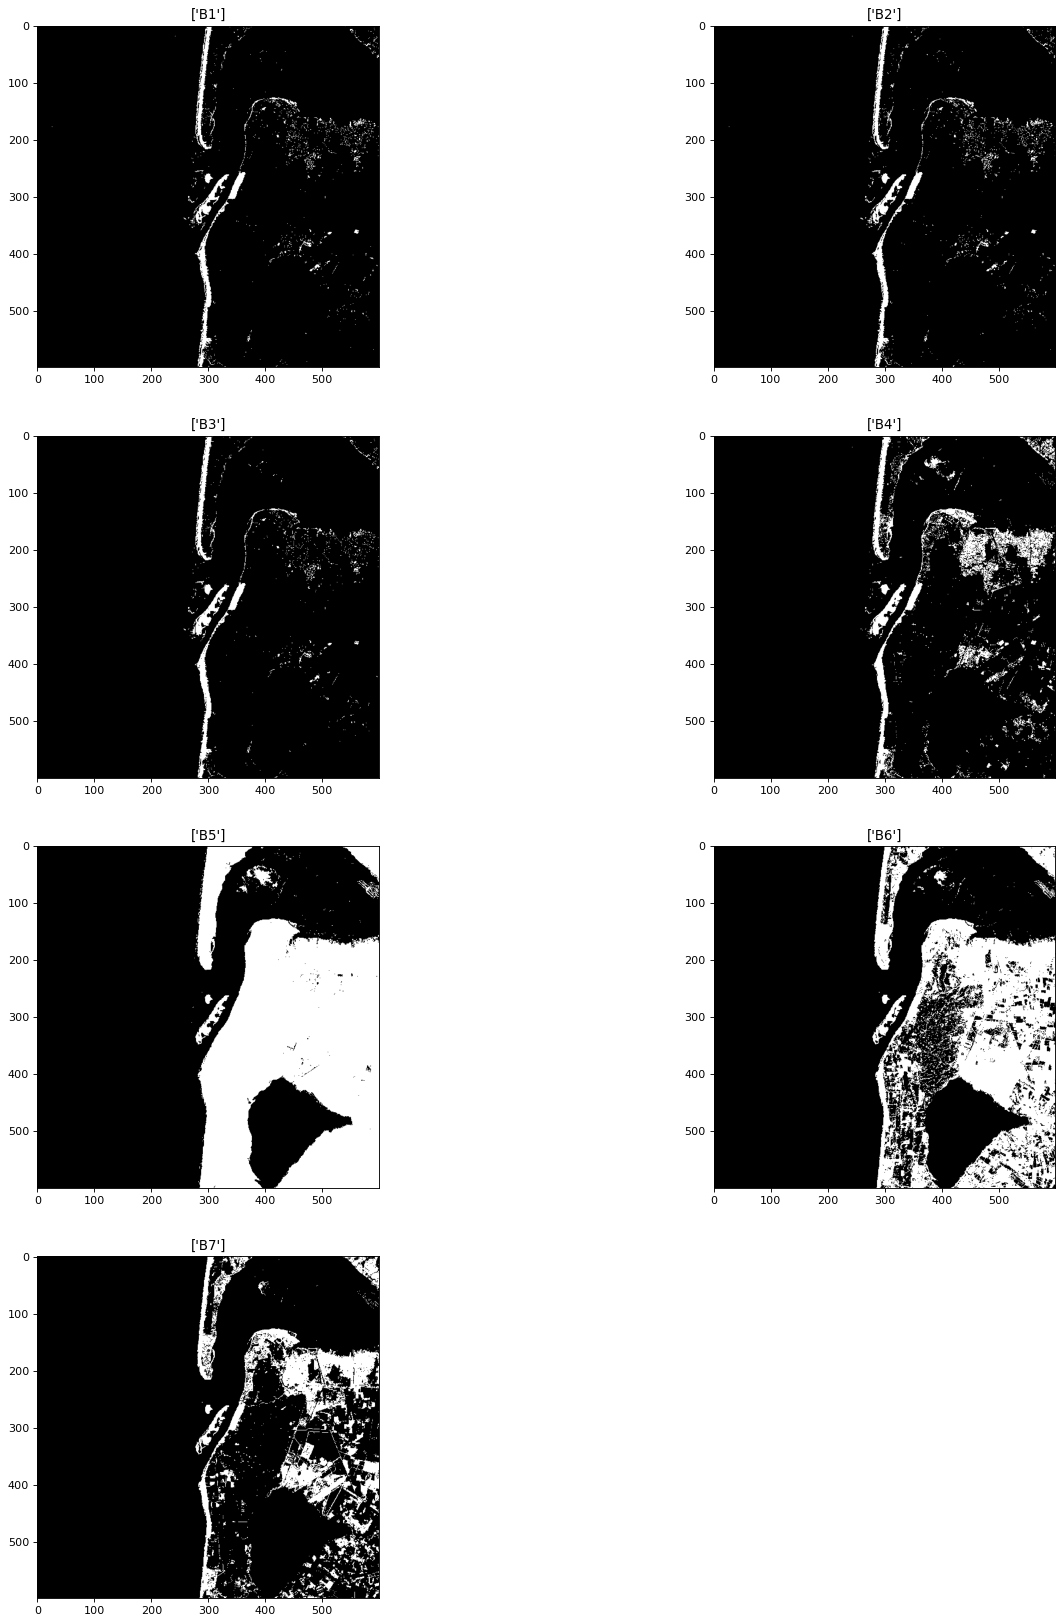

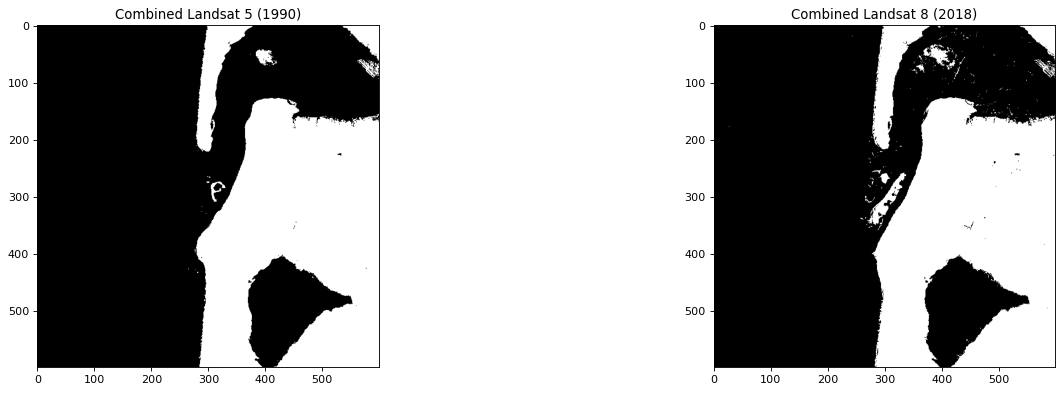

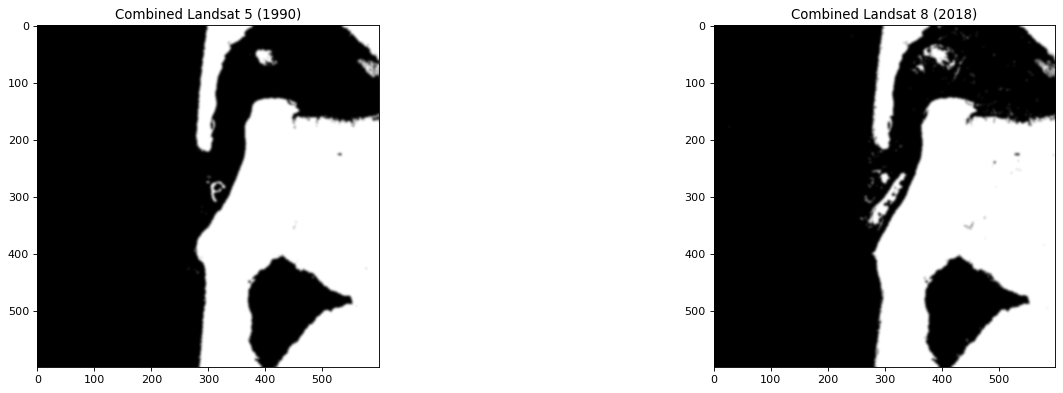

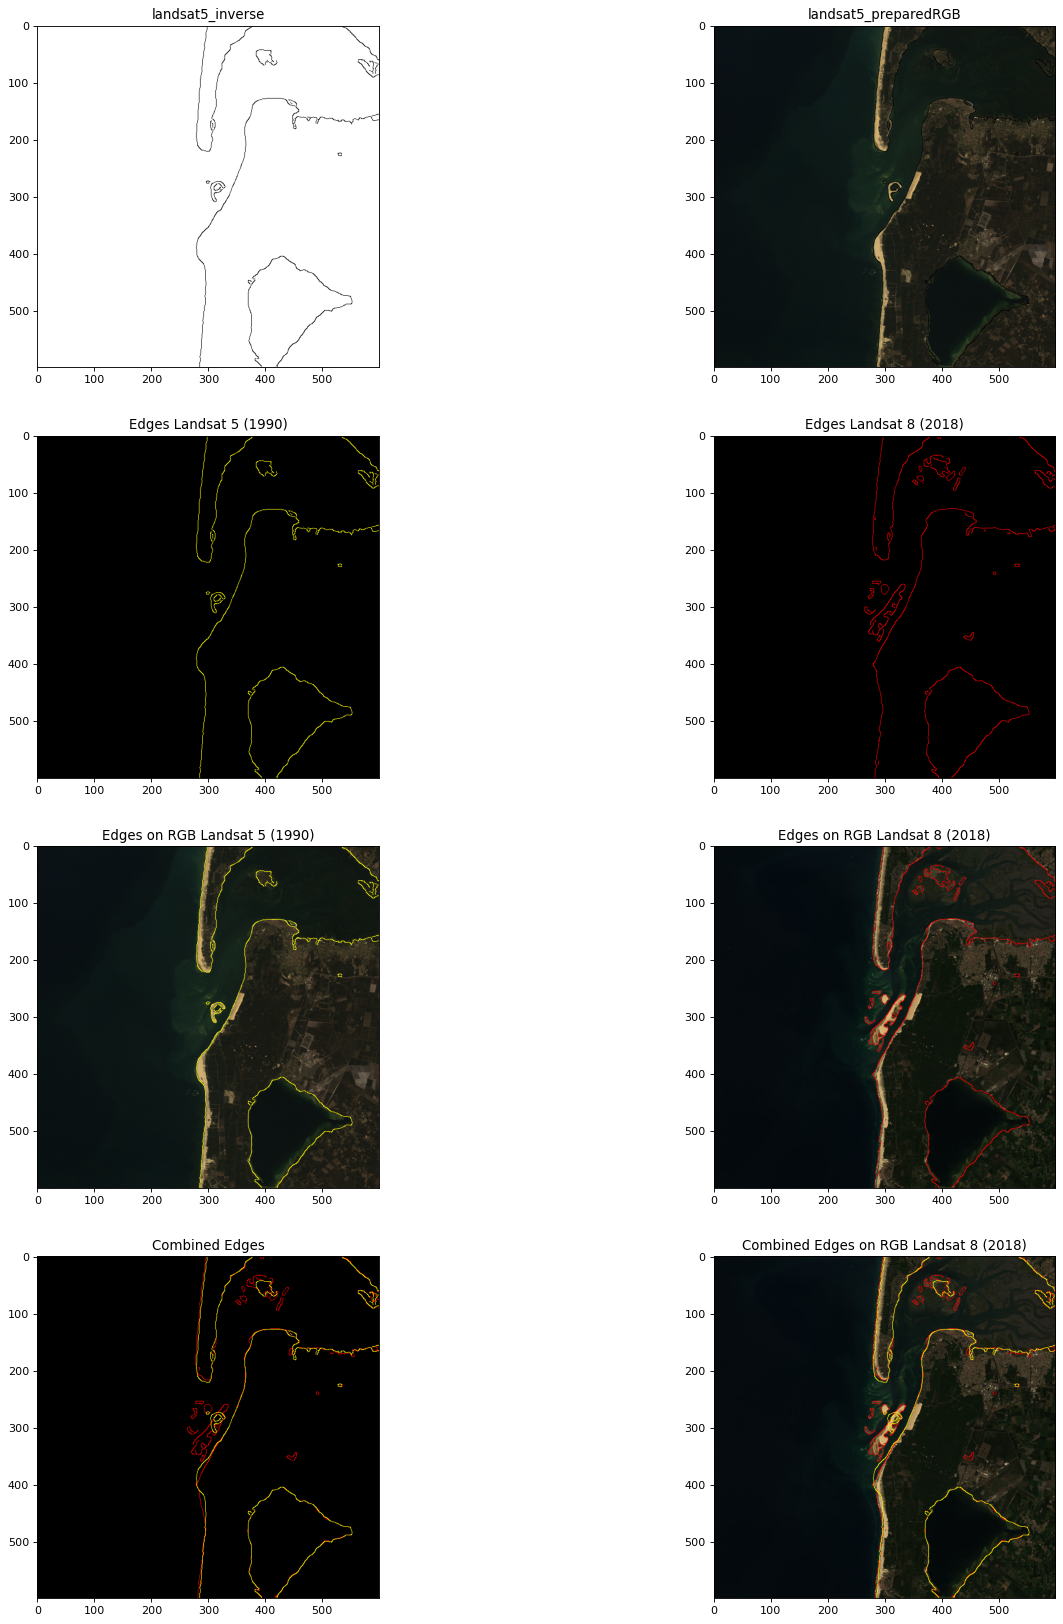

Fullscreen is:  False


In [4]:
# Map = generateMap(None, None, None)
Map = generateMap(-1.248944, 44.580014, 11)
regionOfInterestPoint = ee.Geometry.Point(-1.248944, 44.580014)
isFullscreen = False

def mapChanged(change):
    newChange = change['new']
    if newChange is not None:
        if isinstance(newChange, dict):
            if "fullscreen" in newChange.keys():
                isFullscreen = bool(newChange["fullscreen"])
                print("Fullscreen is: ", newChange["fullscreen"])
                if isFullscreen and imageRetrivalStarted:
                    main()
                

Map.observe(mapChanged)
Map

In [5]:
message = """
Instruction:\n
1. If you would like to go with a default region then ignore step 2
2. If you would like to select your own region please place a marker on the map. 
   The marker icon is on the left of the map above. 
   It looks like a "Google Maps" icon.
3. Whenever you're ready press the fullscreen icon and move your mouse to the 
   edge of the screen
4. The images will load on screen. Please wait until the "Finished" message 
   appears on screen.
"""

if easygui.ccbox(message, "Instructions"):
    imageRetrivalStarted = True
else:
    imageRetrivalStarted = False